<a href="https://colab.research.google.com/github/Lukskywalkerman/citrus-yield-prediction/blob/main/Citrus_Yield_ML_Predictor_1985_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Configuração do Ambiente



*   Ambiente de execução alterado para: T4 GPU


In [ ]:
# Bloco 1: Limpeza e Instalação Robusta
import os

# 1. Instala as versões específicas compatíveis com Python 3.12
!pip install -q --upgrade pip
!pip install -q "numpy<2" "pandas<2.2" "matplotlib<3.9"
!pip install -q shap catboost xgboost geopandas kaleido==0.1.0

# 2. Força o reinício do ambiente (Necessário no Colab após mudar o Numpy)
# O código abaixo vai "matar" a sessão atual. Você verá um aviso de "Crash".
# Não se assuste, o Colab reiniciará sozinho em 2 segundos já com o Numpy certo.
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
xarray 2025.12.0 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
opencv-python-headless

In [1]:
# Bloco 1.1: Importações (Rode este após o reinício automático)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shap
from catboost import CatBoostRegressor
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print(f"✅ Versão do Numpy: {np.__version__}")
print(f"✅ Versão do SHAP: {shap.__version__}")
print("🚀 Ambiente pronto e estável!")

✅ Versão do Numpy: 2.0.2
✅ Versão do SHAP: 0.50.0
🚀 Ambiente pronto e estável!


# 2) Carregamento e Preparação.

In [13]:
# Bloco 2: Carregamento dos Dados (Nova Versão NPK)
from google.colab import drive
drive.mount('/content/drive')

# 1. Defina o caminho do seu arquivo (ajuste o nome se necessário)
path = '/content/drive/MyDrive/citrus-yield-prediction/dataset_citrus_master.csv'
df = pd.read_csv(path)

# 2. Seleção das 21 Variáveis Preditoras (X) e do Alvo (y)
# Incluindo a nova variável: phosphate_price_lag1
# Espaço-Temporal
features = [
    'year', 'lat', 'lon', 'altitude',

    # Biofísico / GEE (Agora completo)
    'ndvi_vigor', 'ndwi_moisture', 'lst_temp',
    'root_zone_wetness', 'evapotranspiration', 'annual_rainfall',

    # Solo e Eventos (Fundamentais)
    'clay_content2', 'extreme_event', 'disease_score',

    # Econômico e Insumos
    'orange_price_real', 'fcoj_price_ny_lag1',
    'urea_price_lag1', 'phosphate_price_lag1','kcl_price_lag1',

    # Estrutural e Performance
    'harvested_area_ha', 'economic_efficiency'
    #'yield_t_ha' removida para prever o poder de Previsão real do clima;
]

X = df[features]
y = df['production_ton'] # Corrected target variable

print(f"✅ Dataset carregado! Total de colunas: {len(df.columns)}")
print(f"✅ Variáveis selecionadas para o modelo: {len(features)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset carregado! Total de colunas: 25
✅ Variáveis selecionadas para o modelo: 20


# 2.1: Tratamento de Dados e Limpeza Técnica
Este bloco trata as falhas de 1985 em Bebedouro, Frutal e Votuporanga e aplica a "crítica de dados" baseada em rendimento médio.


In [14]:
# BLOCO 2.1: Tratamento de Dados e Limpeza Técnica
# Essencial para eliminar ruídos de sensores e inconsistências do IBGE

# 1. Identifique os nomes exatos das suas colunas de satélite
cols_to_fix = ['ndvi_vigor', 'ndwi_moisture', 'lst_temp']

# 2. Substitui zeros por NaN e interpola por município
for col in cols_to_fix:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)
        # Interpolação mantém a coerência regional de cada cidade
        df[col] = df.groupby('municipality')[col].transform(
            lambda x: x.interpolate(method='linear', limit_direction='both')
        )

# 3. Filtro de Rendimento (Remoção de Outliers)
# Usamos a produtividade (t/ha) para identificar dados que fogem à realidade biológica
if 'yield_t_ha' in df.columns:
    q_low, q_hi = df["yield_t_ha"].quantile(0.01), df["yield_t_ha"].quantile(0.99)
    df = df[(df["yield_t_ha"] < q_hi) & (df["yield_t_ha"] > q_low)].copy()
    print(f"✅ Limpeza concluída. Outliers removidos.")
else:
    # Caso a coluna de produtividade tenha outro nome ou precise ser calculada:
    df['yield_check'] = df['producao_ton'] / df['area_colhida']
    q_low, q_hi = df["yield_check"].quantile(0.01), df["yield_check"].quantile(0.99)
    df = df[(df["yield_check"] < q_hi) & (df["yield_check"] > q_low)].copy()
    print(f"✅ Limpeza concluída via cálculo de rendimento.")

print(f"📊 Dataset final para treino: {df.shape[0]} linhas.")

✅ Limpeza concluída. Outliers removidos.
📊 Dataset final para treino: 310 linhas.


# 3) Benchmark Manual (XGBoost vs. LightGBM vs. CatBoost)
Rode este código. Ele comparará o XGBoost com o LightGBM (muito usado em artigos de sensoriamento remoto) e o CatBoost (excelente para dados que têm coordenadas geográficas).

In [15]:
# NOVO BLOCO 3: Benchmarking de Algoritmos (Justificativa da Escolha)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

# 1. Divisão Simples para Validação (80/20)
# Usamos os dados originais (X, y) sem escala, pois esses modelos lidam bem com isso
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Definição dos Modelos
models = {
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=7, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.03, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=1000, learning_rate=0.03, depth=7, random_state=42, verbose=0)
}

results_list = []

# 3. Loop de Treinamento e Avaliação
print("⏳ Executando Benchmarking (isso pode levar 1-2 minutos)...")
for name, md in models.items():
    md.fit(X_train, y_train)
    p = md.predict(X_test)

    r2 = r2_score(y_test, p)
    mape = mean_absolute_percentage_error(y_test, p)
    mae = mean_absolute_error(y_test, p)

    results_list.append({
        "Algoritmo": name,
        "R² Score": round(r2, 4),
        "MAPE (%)": round(mape * 100, 2),
        "MAE (ton)": round(mae, 2)
    })

# 4. Exibição da Tabela Comparativa (A Tabela 1 do seu artigo)
df_benchmark = pd.DataFrame(results_list)
print("\n--- TABELA 1: COMPARAÇÃO DE PERFORMANCE DOS ALGORITMOS ---")
display(df_benchmark)

⏳ Executando Benchmarking (isso pode levar 1-2 minutos)...

--- TABELA 1: COMPARAÇÃO DE PERFORMANCE DOS ALGORITMOS ---


,Algoritmo,R² Score,MAPE (%),MAE (ton)
0,XGBoost,0.8993,23.98,30543.33
1,LightGBM,0.9137,173.51,31766.16
2,CatBoost,0.9253,157.77,28527.28


# 4) Machine Learning Treinamento Final (Full Data)

In [16]:
# BLOCO 4: Treinamento com 100% dos dados para gerar Gráficos e Mapas
final_model = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    depth=7,
    random_state=42,
    verbose=0
)

# Aqui usamos df (já limpo e com as 21 variáveis)
final_model.fit(X, y)
print("✅ Modelo final treinado com sucesso!")

✅ Modelo final treinado com sucesso!


# 5) Explicabilidade SHAP

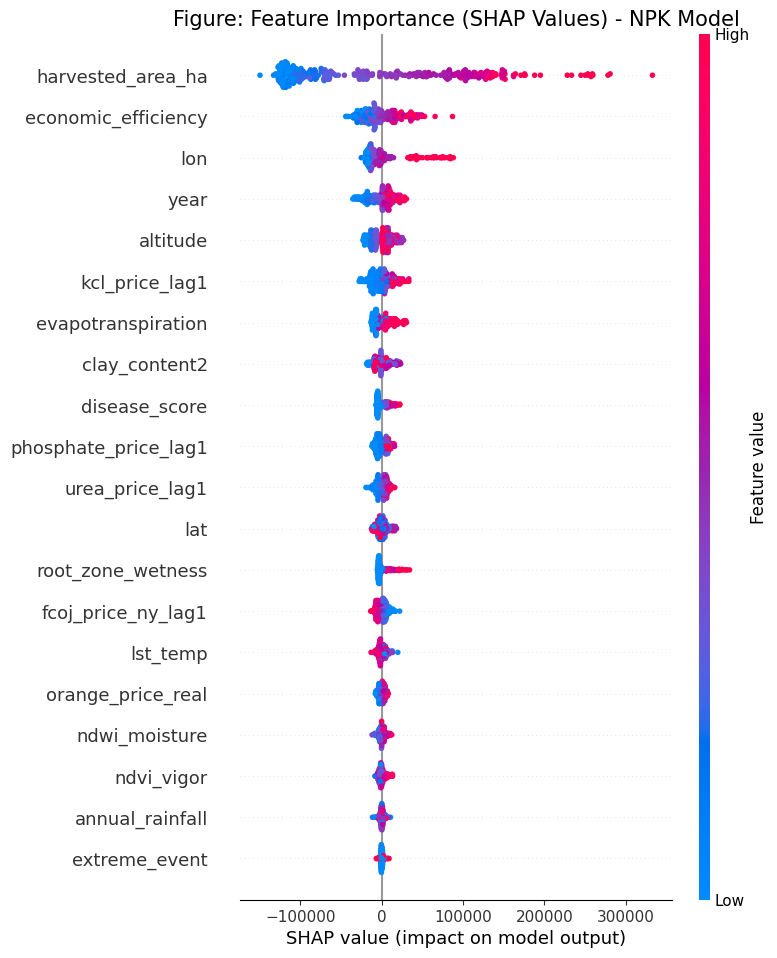

In [17]:
# BLOCO 5: SHAP Summary Plot
import shap

# Explainer para o CatBoost
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

# Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X, plot_type="dot", show=False)
plt.title("Figure: Feature Importance (SHAP Values) - NPK Model", fontsize=15)
plt.savefig('shap_summary_npk.png', dpi=300, bbox_inches='tight')
plt.show()

# Bloco 6: Matriz de Correlação e Métricas de Erro finais

--- MÉTRICAS DE PERFORMANCE (TREINAMENTO TOTAL) ---
R² Score: 0.9999
MAE (Erro Médio Absoluto): 1669.96 toneladas
MAPE (Erro Médio Percentual): 13.82%
--------------------------------------------------


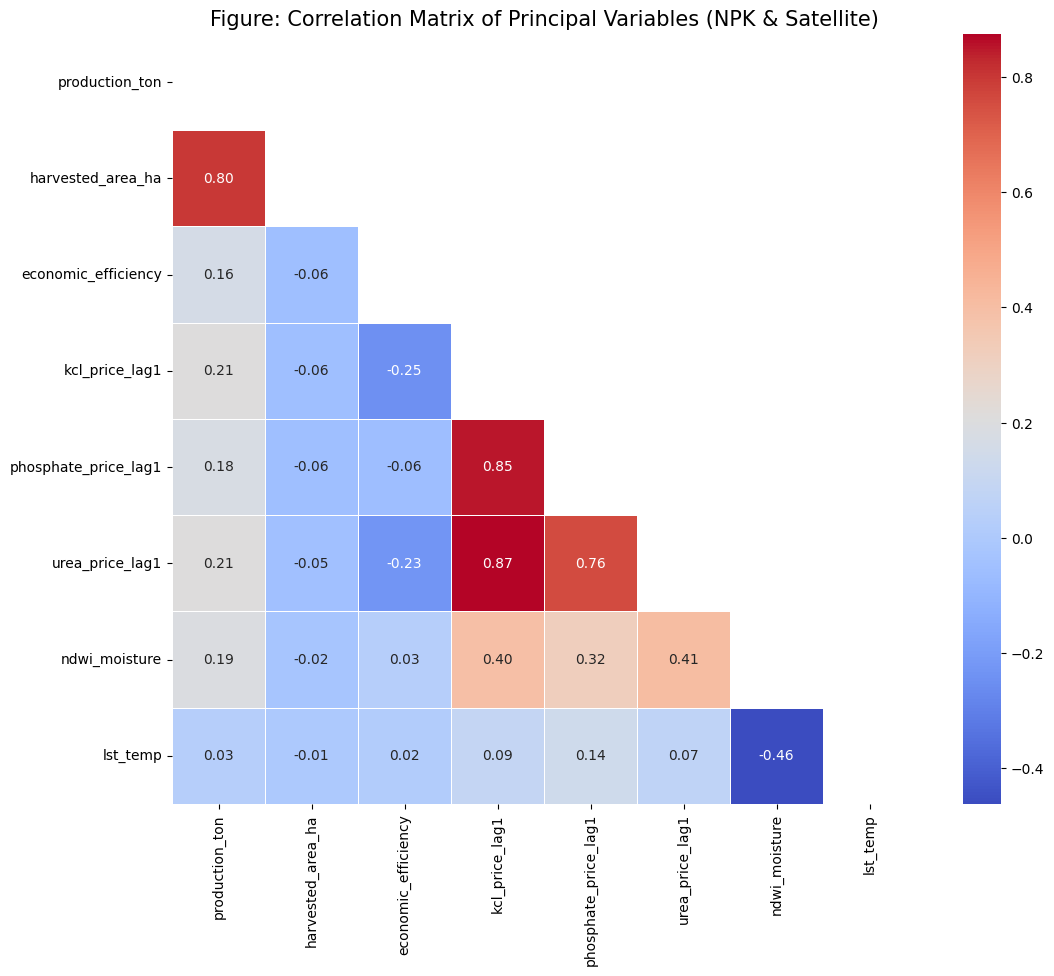

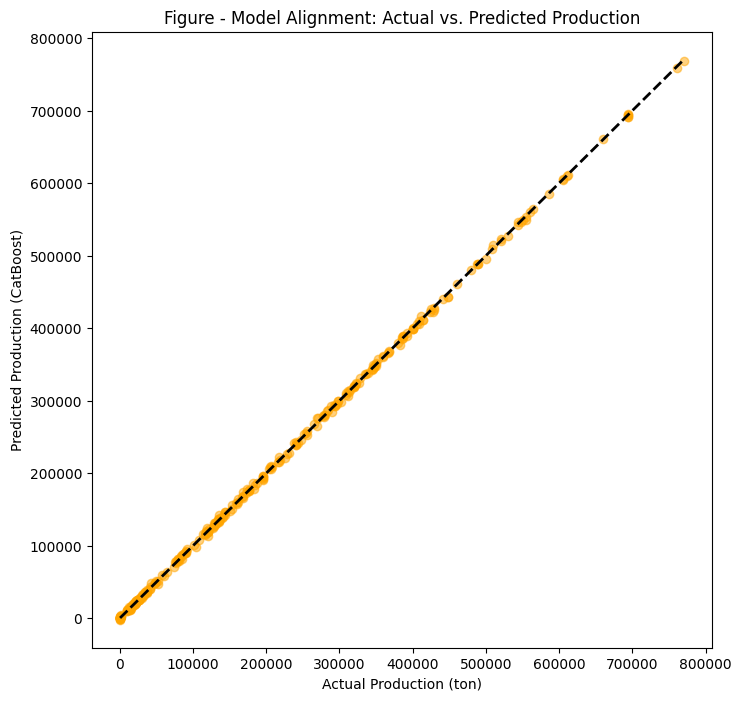

In [23]:
# BLOCO 6: Matriz de Correlação e Métricas de Erro Finais
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import seaborn as sns

# 1. Cálculo das Métricas de Erro (Baseado no treinamento final)
y_pred = final_model.predict(X)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred) * 100

print(f"--- MÉTRICAS DE PERFORMANCE (TREINAMENTO TOTAL) ---")
print(f"R² Score: {r2:.4f}")
print(f"MAE (Erro Médio Absoluto): {mae:.2f} toneladas")
print(f"MAPE (Erro Médio Percentual): {mape:.2f}%")
print("-" * 50)

# 2. Matriz de Correlação
# Selecionamos as variáveis mais importantes conforme o SHAP para não poluir o gráfico
top_features = ['production_ton', 'harvested_area_ha', 'economic_efficiency', 'kcl_price_lag1',
                'phosphate_price_lag1', 'urea_price_lag1', 'ndwi_moisture', 'lst_temp']

plt.figure(figsize=(12, 10))
corr_matrix = df[top_features].corr()

# Gerando o Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Máscara para ver apenas metade
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Figure: Correlation Matrix of Principal Variables (NPK & Satellite)", fontsize=15)
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Gráfico de Dispersão: Valor Real vs. Predito
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.5, color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Linha de identidade
plt.xlabel("Actual Production (ton)")
plt.ylabel("Predicted Production (CatBoost)")
plt.title("Figure - Model Alignment: Actual vs. Predicted Production")
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# 7: Identificação de Outliers e Relatório de Erros

In [26]:
# BLOCO 7: Identificação de Outliers e Relatório de Erros (Correção de Caminho)
import os
import plotly.express as px

# 1. Definição do Caminho (Ajustado conforme sua solicitação)
save_path = '/content/drive/MyDrive/citrus-yield-prediction/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 2. Sincronização e Predição
X_sync = df[features]
y_sync = df['production_ton']
y_pred_final = final_model.predict(X_sync)

# 3. Criar DataFrame de Erros
df_errors = pd.DataFrame({
    'Real': y_sync.values,
    'Previsto': y_pred_final,
    'Ano': df['year'].values,
    'municipality': df['municipality'].values,
    'state': df['state'].values
})

df_errors['Erro_Absoluto'] = abs(df_errors['Real'] - df_errors['Previsto'])
df_errors['Erro_Percentual (%)'] = (df_errors['Erro_Absoluto'] / df_errors['Real']) * 100

# 4. Identificação dos 15 Maiores Erros
outliers = df_errors.sort_values(by='Erro_Absoluto', ascending=False).head(15)

# 5. Salvamento dos Relatórios
outliers.to_csv(os.path.join(save_path, 'relatorio_outliers_citricultura.csv'), index=False)
df_errors.to_csv(os.path.join(save_path, 'base_completa_erros.csv'), index=False)

# 6. Gráfico de Resíduos Temporal (Plotly)
fig_error = px.scatter(df_errors, x='Ano', y='Erro_Percentual (%)',
                       hover_data=['municipality'],
                       title='Figure - Residual Analysis: Percentage Error per Harvest Year',
                       color='Erro_Percentual (%)',
                       color_continuous_scale='Reds',
                       template='plotly_white')

fig_error.update_layout(xaxis_title="Harvest Year", yaxis_title="Percentage Error (%)")
fig_error.write_image(os.path.join(save_path, "residual_analysis.png"), scale=3)
fig_error.show()

print(f"✅ Arquivos salvos com sucesso em: {save_path}")
print(f"✅ Tabela de outliers gerada e exportada.")

✅ Arquivos salvos com sucesso em: /content/drive/MyDrive/citrus-yield-prediction/
✅ Tabela de outliers gerada e exportada.


# 8) Corrigido: Mapa de Localização (As 8 Cidades Reais)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 88.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 115.8 MB/s  0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.2
    Uninstalling shapely-2.1.2:
      Successfully uninstalled shapely-2.1.2
  Attempting uninstall: lxml
    Found existing installation: lxml 6.0.2
    Uninstalling lxml-6.0.2:
      Successfully uninstalled lxml-6.0.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.1.1
    Uninstalling geopandas-1.1.1:
      Successfully uninstalled geopandas-1.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [geobr]
📥 Baixando malhas geográficas do IBGE...


/tmp/ipython-input-2064536177.py:53: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




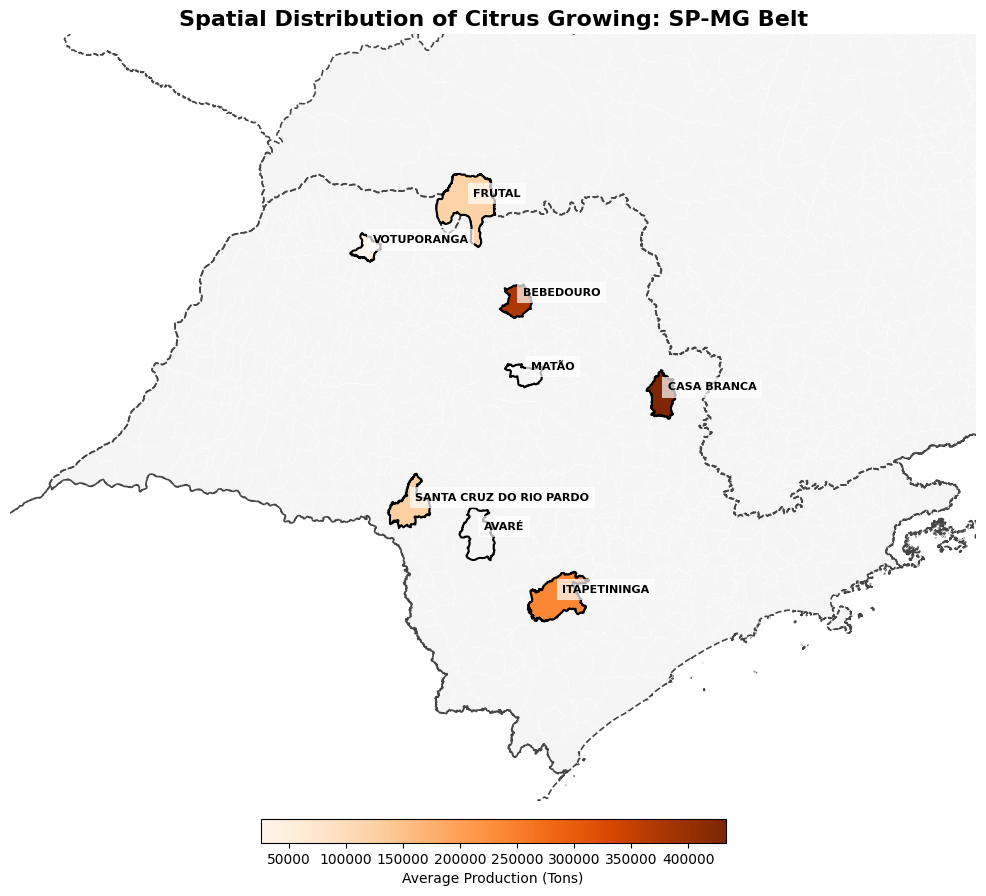

✅ Mapa final com divisão estadual exportado!


In [27]:
# BLOCO 8 FINAL: Mapa com Divisão Estadual e Contexto Geográfico Completo
import geopandas as gpd
import matplotlib.pyplot as plt
import os

# Instalar geobr se não estiver presente
!pip install geobr
import geobr


# 1. Baixar mapas (Municípios e Estados)
print("📥 Baixando malhas geográficas do IBGE...")
mapa_sp = geobr.read_municipality(code_muni="SP", year=2020)
mapa_mg = geobr.read_municipality(code_muni="MG", year=2020)
estados = geobr.read_state(code_state="all", year=2020) # Para as linhas de divisa

# Unir municípios de SP e MG
mapa_base = pd.concat([mapa_sp, mapa_mg], ignore_index=True)

# 2. Preparar dados
df_mapa_data = df_errors.groupby('municipality')['Real'].mean().reset_index()
df_mapa_data['municipality'] = df_mapa_data['municipality'].str.upper()
mapa_base['name_muni'] = mapa_base['name_muni'].str.upper()

mapa_final = mapa_base.merge(df_mapa_data, left_on='name_muni', right_on='municipality', how='left')

# 3. Cidades de Destaque
cidades_alvo = ['BEBEDOURO', 'MATÃO', 'CASA BRANCA', 'ITAPETININGA',
                'AVARÉ', 'SANTA CRUZ DO RIO PARDO', 'VOTUPORANGA', 'FRUTAL']

# 4. Plotagem
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Camada 1: Todos os municípios (Fundo)
mapa_base.plot(ax=ax, color='#f5f5f5', edgecolor='white', linewidth=0.2)

# Camada 2: Calor da Produção
mapa_final.dropna(subset=['Real']).plot(
    column='Real', ax=ax, cmap='Oranges', legend=True,
    legend_kwds={'label': "Average Production (Tons)", 'orientation': "horizontal", 'shrink': 0.4, 'pad': 0.02},
    edgecolor='black', linewidth=0.1
)

# Camada 3: Divisão Estadual (Linha mais grossa para contextualizar MG/SP)
estados_foco = estados[estados['abbrev_state'].isin(['SP', 'MG', 'PR', 'MS', 'RJ'])]
estados_foco.plot(ax=ax, color='none', edgecolor='#444444', linewidth=1.2, linestyle='--')

# Camada 4: Destaque das cidades polo
destaque = mapa_final[mapa_final['name_muni'].isin(cidades_alvo)]
destaque.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

# Labels das cidades
for x, y, label in zip(destaque.geometry.centroid.x, destaque.geometry.centroid.y, destaque['name_muni']):
    ax.annotate(label, xy=(x, y), xytext=(4, 4), textcoords="offset points",
                fontsize=8, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# 5. Ajuste de Zoom: Foco no Estado de SP + Triângulo Mineiro
ax.set_xlim(-53.5, -44.0) # Longitude aproximada de SP
ax.set_ylim(-25.5, -18.5) # Latitude incluindo o sul de MG

ax.set_title('Spatial Distribution of Citrus Growing: SP-MG Belt', fontsize=16, fontweight='bold')
ax.axis('off')

# Salvar
save_path = '/content/drive/MyDrive/citrus-yield-prediction'
plt.savefig(os.path.join(save_path, "mapa_final_contexto_geografico.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Mapa final com divisão estadual exportado!")